# Bayesian A/B testing with pymc3

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import warnings
import matplotlib as mpl

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
sns.set_style("whitegrid")

if True:    
    warnings.filterwarnings('ignore')

In [11]:
ab = ([5771, 12364,2127, 6911], [5771, 8164, 300, 1000])
ab = np.array(ab)
df = pd.DataFrame(ab)
#df = df.assign(average = lambda x: x.h / x.ab)
#df = df.T 
df.columns = ["treatment_x", "treatment_n", "control_x", "control_n"]
df

,treatment_x,treatment_n,control_x,control_n
0,5771,12364,2127,6911
1,5771,8164,300,1000


In [5]:
em_bayes = pm.Model()

with em_bayes:
    
    treatment_p = pm.Beta("treat_sample", 1, 1, shape=df.shape[0])
    control_p = pm.Beta("control_sample", 1, 1, shape=df.shape[0])
    
    treat_lik = pm.Binomial("treatlik", n=df.treatment_n, p=treatment_p, observed=df.treatment_x)
    control_lik = pm.Binomial("conlik", n=df.control_n, p=control_p, observed=df.control_x)
    
    diff = pm.Deterministic("p_diff", treatment_p - control_p) # this is the key line - is the differnce between treamtment and control response rates different
    
print("model compiled")

with em_bayes:
    mcmc = pm.sample(2000, n_jobs=-1)
    
print("Sampling complete")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


model compiled


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [control_sample_logodds__, treat_sample_logodds__]
100%|██████████| 2500/2500 [00:02<00:00, 1070.03it/s]


Sampling complete


In [16]:
class BayesianAB:
    
    def __init__(self):
        self.model = pm.Model()
        pass
    
    def fit(self):
        
        with self.model:
    
            treatment_p = pm.Beta("treat_sample", 1, 1, shape=df.shape[0])
            control_p = pm.Beta("control_sample", 1, 1, shape=df.shape[0])

            treat_lik = pm.Binomial("treatlik", n=df.treatment_n, p=treatment_p, observed=df.treatment_x)
            control_lik = pm.Binomial("conlik", n=df.control_n, p=control_p, observed=df.control_x)

            diff = pm.Deterministic("p_diff", treatment_p - control_p) # this is the key line - is the differnce between treamtment and control response rates different

            mcmc = pm.sample(2000, n_jobs=-1)

            return mcmc

In [17]:
bab = BayesianAB()

In [18]:
trace = bab.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [control_sample_logodds__, treat_sample_logodds__]
100%|██████████| 2500/2500 [00:01<00:00, 1755.31it/s]


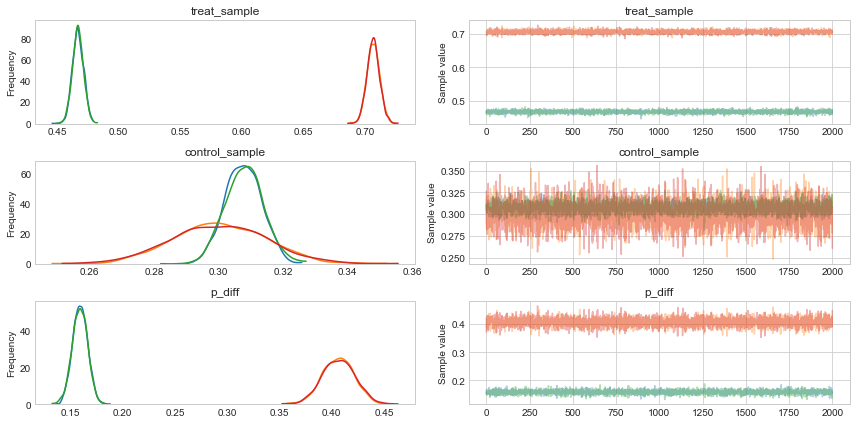

In [20]:
pm.traceplot(trace);

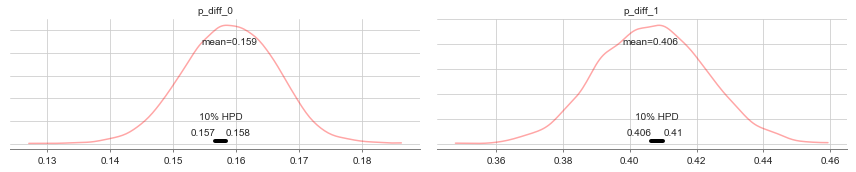

In [8]:
pm.plot_posterior(mcmc, varnames=["p_diff"], alpha_level=0.9, color="r", kde_plot=True);

In [75]:
trace_df = pm.trace_to_dataframe(mcmc)
trace_df.head()
#(trace_df.a > trace_df.b).sum() / trace_df.shape[0]

,treat_sample__0,treat_sample__1,control_sample__0,control_sample__1
0,0.459140,0.699671,0.311506,0.296240
1,0.460805,0.709894,0.310565,0.297485
2,0.471776,0.707578,0.311140,0.280282
3,0.467456,0.704887,0.305332,0.298083
4,0.467456,0.704887,0.305332,0.298083


In [104]:
trace_df_rs = trace_df.unstack().reset_index(drop=False, name="sample_p")
trace_df_rs = trace_df_rs.assign(group = lambda x: "test_" + x.iloc[:, 0].str[-1])

In [111]:
pm.summary(mcmc)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
treat_sample__0,0.466748,0.004473,0.000056,0.458092,0.475571,4000.0,0.999877
treat_sample__1,0.706796,0.004961,0.000054,0.697468,0.716723,4000.0,0.999761
control_sample__0,0.307796,0.005712,0.000073,0.296614,0.318487,4000.0,0.999770
control_sample__1,0.300493,0.014403,0.000190,0.273048,0.328920,4000.0,1.000082
p_diff__0,0.158952,0.007310,0.000091,0.144056,0.172788,4000.0,0.999857
p_diff__1,0.406303,0.015136,0.000201,0.375417,0.434796,4000.0,1.000013


In [73]:
em_bayes = pm.Model()
with em_bayes:
    sh1 = pm.Normal("sh1", mu=df.h.mean(), sd=500)
    sh2 = pm.Normal("sh2", mu=df.ab.mean(), sd=3000)
    
    bpr = pm.Beta("bpr", sh1 + df.h, sh2 + df.ab - df.h, observed=df.average)
    
    updated = pm.sample(5000, tune=500)[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/conormd/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sh2, sh1]
100%|██████████| 5500/5500 [00:08<00:00, 637.41it/s]
The number of effective samples is smaller than 25% for some parameters.


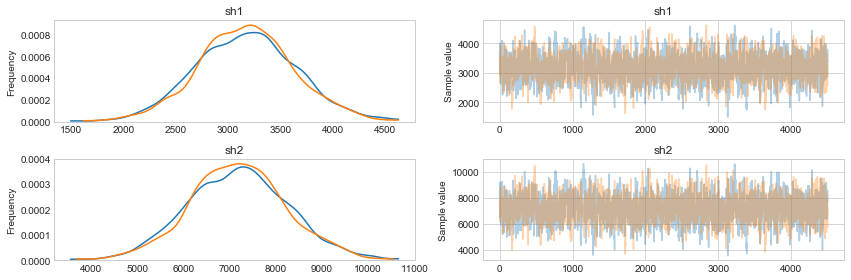

In [74]:
pm.traceplot(updated);

In [75]:
post = pm.trace_to_dataframe(updated)
post.head(10)

,sh1,sh2
0,3728.285830,8579.041970
1,3454.271504,7895.590680
2,3454.271504,7895.590680
3,3776.740367,8471.808696
4,3795.639595,8786.939840
5,2971.492790,6544.783806
6,2925.279606,6454.709420
7,4003.108342,9220.345161
8,3811.807688,8625.622859
9,3348.642217,7723.747692


In [76]:
model_sum = pm.summary(updated)
model_sum

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sh1,3172.631254,467.741021,12.390463,2237.057332,4097.340597,1355.0,0.99989
sh2,7181.954537,1065.715784,28.332701,5050.282211,9273.727465,1358.0,0.99989


In [77]:
df["eb_estimate"] = (df.h + model_sum["mean"][0]) / (df.ab + model_sum["mean"][0] + model_sum["mean"][1])

In [78]:
# update estimate
df

,h,ab,average,eb_estimate
arron,3771,12364,0.304998,0.305637
piazza,2127,6911,0.307770,0.306948


In [79]:
def eb_estimate(h, ab, model):
    est = (h + model.sh1) / (ab + model.sh1 + model.sh2)
    return est

In [84]:
eb_estimate(5000, 6000, model=post)

0       0.476765
1       0.487282
2       0.487282
3       0.480956
4       0.473327
5       0.513750
6       0.515298
7       0.468340
8       0.477930
9       0.489014
10      0.496462
11      0.495960
12      0.495960
13      0.491476
14      0.499868
15      0.521872
16      0.512376
17      0.500319
18      0.510673
19      0.504445
20      0.494183
21      0.501076
22      0.500525
23      0.498198
24      0.523789
25      0.500472
26      0.503020
27      0.513704
28      0.518592
29      0.513071
          ...   
8970    0.520099
8971    0.536768
8972    0.527669
8973    0.500470
8974    0.496860
8975    0.503073
8976    0.517996
8977    0.515189
8978    0.499767
8979    0.524431
8980    0.492753
8981    0.495157
8982    0.535904
8983    0.481908
8984    0.507822
8985    0.498986
8986    0.500353
8987    0.508771
8988    0.497877
8989    0.493525
8990    0.496673
8991    0.488805
8992    0.486240
8993    0.494994
8994    0.505370
8995    0.510612
8996    0.511055
8997    0.4982

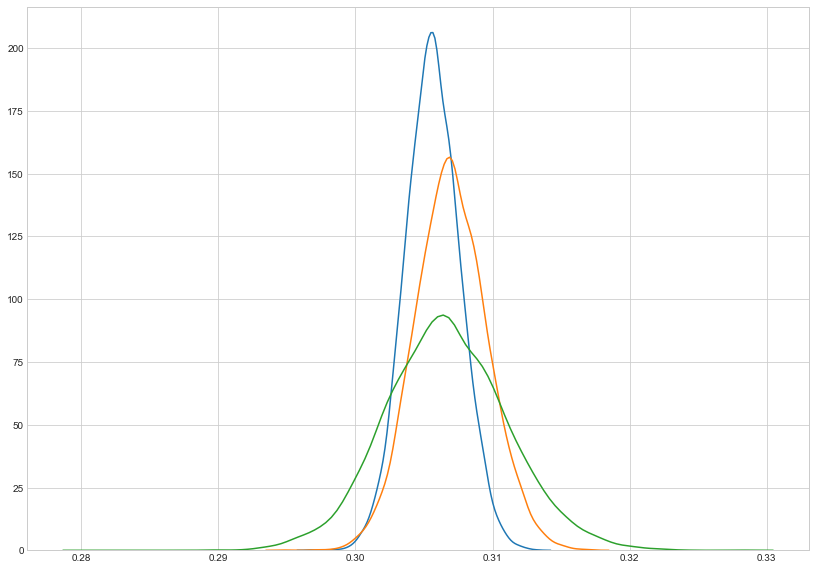

In [87]:
sns.kdeplot(eb_estimate(3771, 12364, model=post))
sns.kdeplot(eb_estimate(2127, 6911, model=post))
#sns.kdeplot(eb_estimate(4000, 5000, model=post))
sns.kdeplot(eb_estimate(4, 7, model=post))

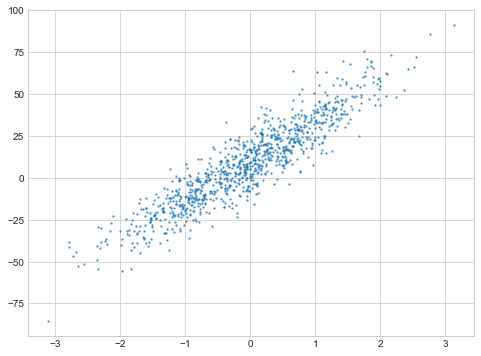

In [2]:
n = 1000
x = np.random.normal(size=n)
y = 10 + 23 * x + np.random.normal(loc=0, scale=10, size=n)
plt.scatter(x, y, alpha = .6, s=2);

In [4]:
lm = pm.Model()
with lm:
    
    a = pm.Normal("a", 5, sd=3)
    b = pm.Normal("b", .9, sd=3)
    e = pm.HalfCauchy("e", 1)
    
    u = a + b * x 
    yhat = pm.Normal("yhat", u, e, observed=y)
    
    out = pm.sample(500)

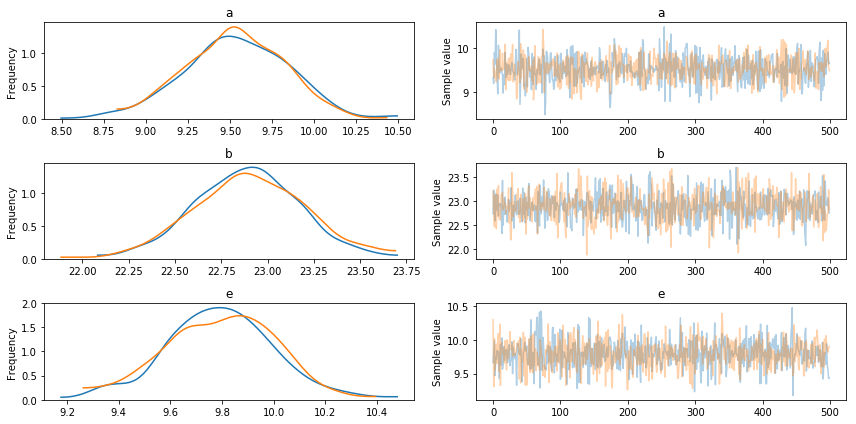

In [6]:
pm.traceplot(out);

In [8]:
yhat_preds = pm.sample_ppc(out, model=lm, samples=10)

100%|██████████| 10/10 [00:00<00:00, 143.96it/s]


In [15]:
yhat_preds = yhat_preds["yhat"].T

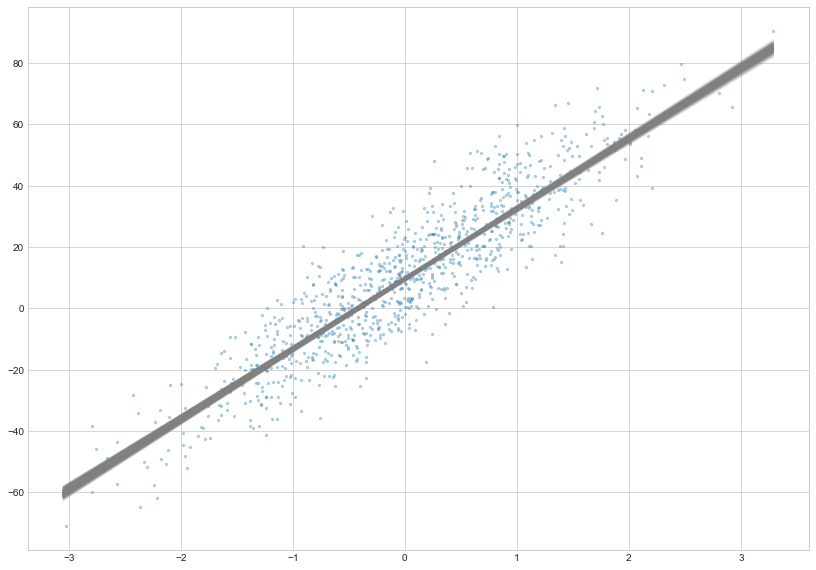

In [89]:
plt.scatter(x, y, alpha=.3, s=5)
for i in range(500):
    plt.plot(x, out["a"][i] + out["b"][i] * x, alpha=.05, c="gray")

Text(0,0.5,'coefficient b space')

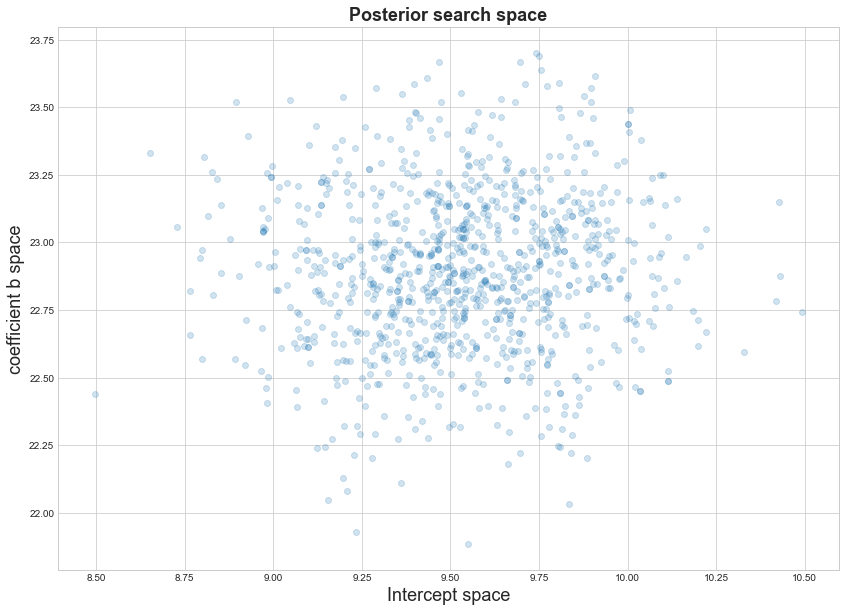

In [100]:
fontsize = 18
plt.scatter(out["a"], out["b"], alpha=.2)
plt.title("Posterior search space", fontsize=fontsize, fontweight="bold")
plt.xlabel("Intercept space", fontsize=fontsize)
plt.ylabel("coefficient b space", fontsize=fontsize)

In [40]:
yhat_e = yhat["yhat"].mean(0)

In [56]:
np.mean(np.sqrt(((y - yhat_e)**2)))

8.670008597171282

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [65]:
print(mean_squared_error(y, yhat_e))
print(mean_absolute_error(y, yhat_e))

118.4148455795526
8.670008597171282


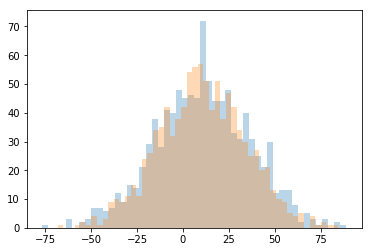

In [73]:
plt.hist(y, alpha=0.3, bins=50);
plt.hist(yhat_e, alpha=0.3, bins=50);

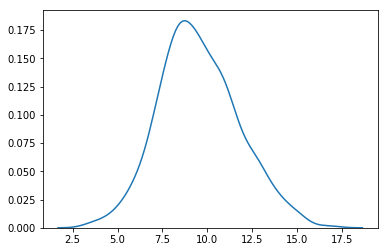

In [79]:
sns.kdeplot(yhat["yhat"].std(0));

In [85]:
out["a"].std()

0.3064425323974895

In [87]:
pm.summary(out)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,10.228455,0.306443,0.009300,9.683504,10.870036,1000.0,0.999076
b,22.523223,0.301631,0.008533,21.988508,23.175495,1000.0,1.005909
e,10.368289,0.236845,0.006434,9.946983,10.871511,1000.0,0.999101


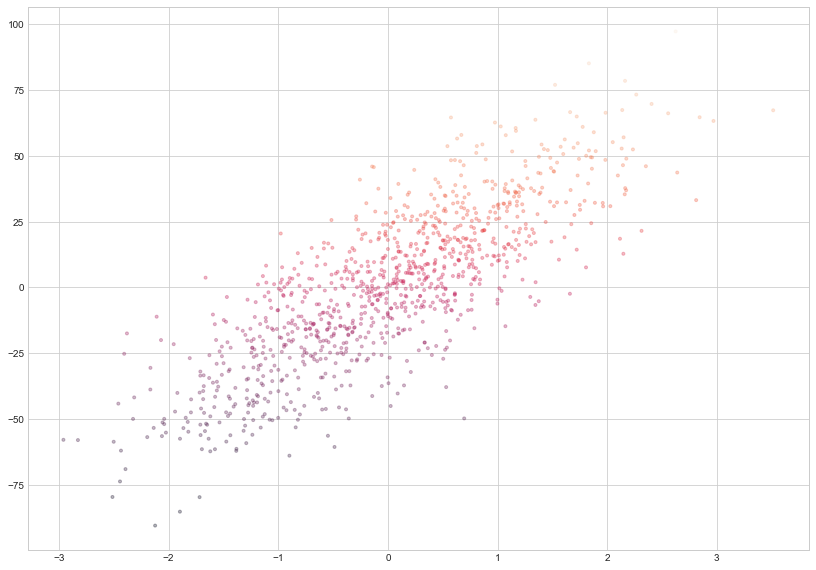

In [121]:
n = 1000
x = np.random.normal(size=n)
y = 0.7 + 23 * x + np.random.normal(scale=17, size=n)
c = (y < 0)
plt.scatter(x, y, alpha=.3, s=9, c=y)


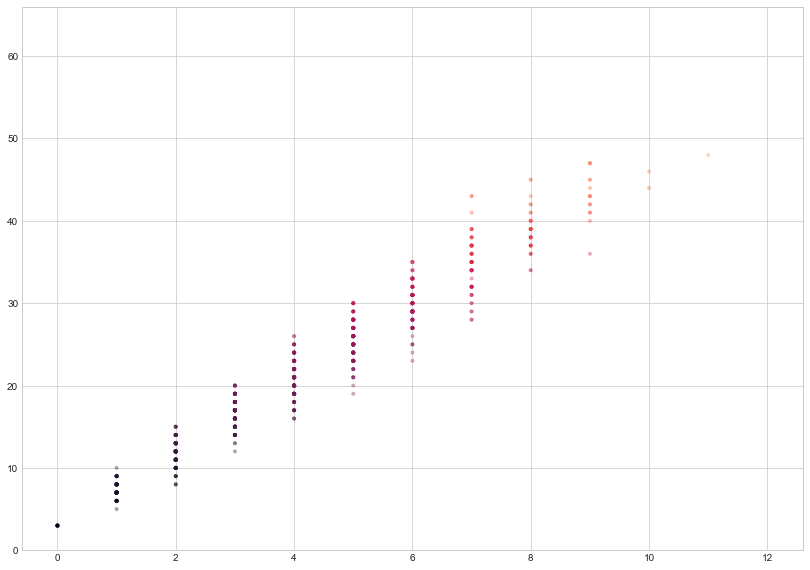

In [40]:
x = np.random.poisson(4, size=1000)
y = np.round(3 + 4.5 * x + np.random.normal(scale=np.sqrt(x), size=1000)).astype(np.int)
plt.scatter(x, y, alpha=.3, s=9, c=y) 

In [50]:
pois_model = pm.Model()

with pois_model:
    
    b0 = pm.Normal("b0", 0, 1)
    b1 = pm.Normal("b1", 0, 1)
    #err = pm.HalfCauchy("err", 1)
    
    yi = b0 + b1 * x
    like = pm.Poisson("like", np.exp(yi), observed=y)
    
    out = pm.sample(2000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/conormd/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b1, b0]
100%|██████████| 2500/2500 [00:02<00:00, 932.40it/s]
The acceptance probability does not match the target. It is 0.9215760906177214, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d933588>,
      dtype=object)

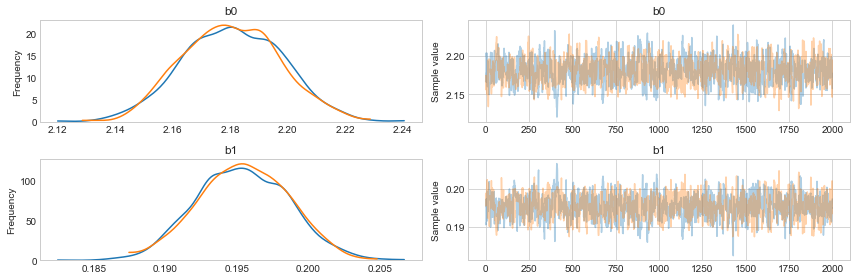

In [51]:
pm.traceplot(out)

In [22]:
myll = [list("abhsc"), list("dsjkdhsjdsh")]
print(myll)

[['a', 'b', 'h', 's', 'c'], ['d', 's', 'j', 'k', 'd', 'h', 's', 'j', 'd', 's', 'h']]


In [23]:
for l in myll:
    for lt in l:
        print(lt)

a
b
h
s
c
d
s
j
k
d
h
s
j
d
s
h


In [36]:
def lazy_flatten(l):
    for i in l:
        yield from i

In [35]:
(list(printletters(myll)))

['a',
 'b',
 'h',
 's',
 'c',
 'd',
 's',
 'j',
 'k',
 'd',
 'h',
 's',
 'j',
 'd',
 's',
 'h']

In [34]:
[i for j in myll for i in j]

['a',
 'b',
 'h',
 's',
 'c',
 'd',
 's',
 'j',
 'k',
 'd',
 'h',
 's',
 'j',
 'd',
 's',
 'h']

In [38]:
list(flatten(myll))

['a',
 'b',
 'h',
 's',
 'c',
 'd',
 's',
 'j',
 'k',
 'd',
 'h',
 's',
 'j',
 'd',
 's',
 'h']

In [41]:
l = [[1, 2, 3], [4, 5, 6], [7], [8, 9]]

def lazy_flatten(l):
    for i in l:
        yield from i

list(lazy_flatten(l))

[1, 2, 3, 4, 5, 6, 7, 8, 9]